Name: Chaitanya Sharadchandra Patil  
PID: A53311586

Academic Integrity Policy: Integrity of scholarship is essential for an academic community. The University expects that both faculty and students will honor this principle and
in so doing protect the validity of University intellectual work. For students, this means
that all academic work will be done by the individual to whom it is assigned, without
unauthorized aid of any kind.  
By including this in my report, I agree to abide by the Academic Integrity Policy mentioned above.

### Problem 1

The goal of this problem is to implement a function for AHE as described in Chapter 1 of
Adaptive Histogram Equalization - A Parallel Implementation.   
The function has the following
specifications:

* The desired function AHE() takes two inputs: the image im and the contextual region size win size.

* Using the pseudocode in Algorithm 1 as a reference, compute the enhanced image after AHE.

* You may use loops if necessary. You should not make use of any inbuilt MATLAB/Python functions for AHE or HE.

* The function returns one output: the enhanced image after AHE.

In [87]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import cv2
import skimage.morphology as skim_morph
import scipy.ndimage.measurements as scipy_im_measure
import pandas as pd
from lloyd_python import lloyds

In [3]:
beach = cv2.imread('beach.png', 0)

In [4]:
type(beach)

numpy.ndarray

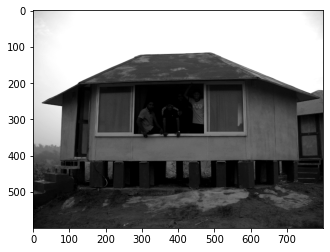

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(beach, cmap = 'gray');

##### Normal histogram equalization

In [6]:
he_beach = cv2.equalizeHist(beach)

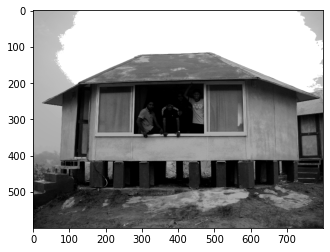

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(he_beach, cmap = 'gray');

##### Adaptive Histogram Equalization

In [8]:
def AHE(im, win_size):
    
    edge_offset = win_size//2
    im_padded = np.pad(im, win_size//2, mode = 'symmetric')
    ahe_im_padded = np.zeros(im_padded.shape)

    # taking only the pixels which can have a legit contextual region
    for i in tqdm(range(edge_offset,im_padded.shape[0]-edge_offset)):
        for j in range(edge_offset,im_padded.shape[1]-edge_offset):

            rank = 0

            contextual_region = im_padded[i-edge_offset:i+edge_offset,j-edge_offset:j+edge_offset]

            for m in range(contextual_region.shape[0]):
                for n in range(contextual_region.shape[1]):
                    if(im_padded[i,j]>contextual_region[m,n]):
                        rank = rank + 1
            ahe_im_padded[i,j] = rank*255/(win_size**2)
            
    ahe_im = ahe_im_padded[edge_offset:(im_padded.shape[0]-edge_offset),edge_offset:(im_padded.shape[1]-edge_offset)]
    
    return(ahe_im)

In [9]:
ahe_im_33 = AHE(beach, 33)
ahe_im_65 = AHE(beach, 65)
ahe_im_129 = AHE(beach, 129)

In [10]:
fig = plt.figure(figsize = (15,15))
ax_orig = fig.add_subplot(321)
ax_orig.imshow(beach, cmap = 'gray')
ax_orig.set_title('Original')

ax_he = fig.add_subplot(322)
ax_he.imshow(he_beach, cmap = 'gray')
ax_he.set_title('Normal Histogram Equalization')

ax_33 = fig.add_subplot(323)
ax_33.imshow(ahe_im_33, cmap = 'gray')
ax_33.set_title('AHE with window size 33')

ax_65 = fig.add_subplot(324)
ax_65.imshow(ahe_im_65, cmap = 'gray')
ax_65.set_title('AHE with window size 65')

ax_129 = fig.add_subplot(325)
ax_129.imshow(ahe_im_129, cmap = 'gray')
ax_129.set_title('AHE with window size 129');

### Binary Morphology

#### Problem 2 Part 1


In [3]:
bin_image = image.imread('circles_lines.jpg')

In [4]:
bin_im_1_chan = np.mean(bin_image, axis = 2)

Text(0.5, 1.0, 'Original Image')

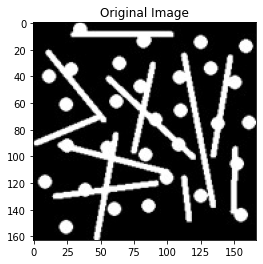

In [5]:
plt.imshow(bin_im_1_chan, cmap = 'gray')
plt.title('Original Image')

Reference: https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html

In [9]:
selem = skim_morph.disk(4)
bin_opened = skim_morph.opening(bin_im_1_chan, selem)

Text(0.5, 1.0, 'Image after opening')

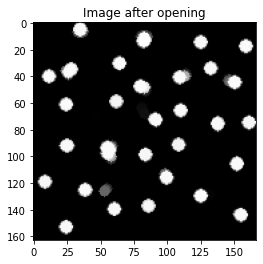

In [10]:
plt.imshow(bin_opened, cmap = 'gray')
plt.title('Image after opening')

Thresholding

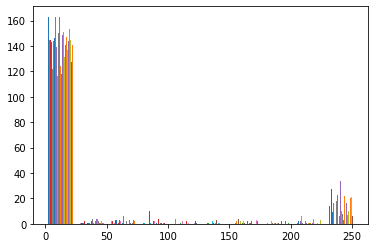

In [11]:
plt.hist(bin_opened);

Observing the histogram above, and considering we want to remove the gray areas and convert them to black, we threshold the image with intensity as 225.

In [13]:
thresholded_bin = np.zeros(bin_opened.shape)

In [14]:
thresholded_bin = np.where(bin_opened>225.0, 1, 0)

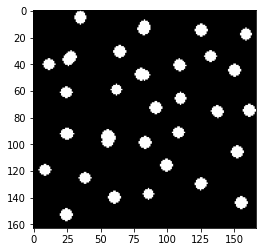

In [15]:
plt.imshow(thresholded_bin, cmap = 'gray')

Once we have a binary image with just the circles, the individual regions need to be
labeled to represent distinct objects in the image i.e. connected component labeling.
This can be done in Python using scipy.ndimage.measurements.label().

#### Labelling

In [80]:
strel = np.ones((3,3))

In [81]:
# input image is thresholded_bin
thresholded_bin_labeled, num = scipy_im_measure.label(thresholded_bin, strel)

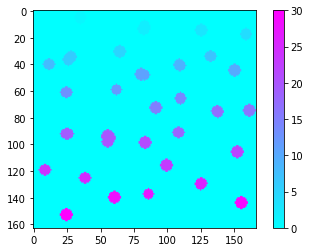

In [82]:
fig = plt.figure()
ax = fig.add_subplot()
mappa = ax.imshow(thresholded_bin_labeled, cmap = 'cool')
fig.colorbar(mappa);

For each labeled region, calculate centroid and area.  
strategy: using np.where for label == 1 extract all the indices. The indices contain information about the position of the features. Once we get the indices, we take mean to get centroid, and take count to get area in pixels.  


For visibility, we also mark the labelled points with a red x.

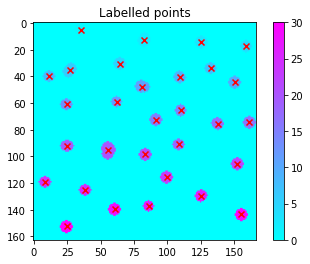

In [83]:
fig_scp = plt.figure()
ax_scp = fig_scp.add_subplot()
mappa2 = ax_scp.imshow(thresholded_bin_labeled, cmap = 'cool')

centroid_list = []
centroid_areas = []

for i in range(1,num+1):
    # extract positions of label
    pos = np.asarray(np.where(thresholded_bin_labeled == i))
    # take mean of the pos
    centroid_pos = np.mean(pos, axis = 1)
    ax_scp.scatter(centroid_pos[1], centroid_pos[0], marker = 'x', c = 'r')
    
    centroid_list.append(centroid_pos)
    centroid_areas.append(pos.shape[1])
    
ax_scp.set_title('Labelled points');
fig_scp.colorbar(mappa2);

Tabulating these values

In [84]:
circle_index = [i+1 for i in range(num)]
circle_index_df = pd.DataFrame(circle_index)
df = pd.DataFrame(centroid_list, columns=['Row number', 'Column number'])
df2 = pd.DataFrame(centroid_areas, columns = ['Area of circle'])
df3 = pd.concat([circle_index_df, df,df2], axis = 1)
df3

,0,Row number,Column number,Area of circle
0,1,5.000000,35.000000,67
1,2,12.719512,82.731707,82
2,3,14.500000,125.500000,68
3,4,17.500000,159.000000,58
4,5,30.500000,64.500000,68
5,6,35.500000,27.000000,82
6,7,34.000000,132.500000,58
7,8,40.000000,11.500000,58
8,9,40.671875,109.328125,64
9,10,44.500000,150.500000,68


The structuring element I used for opening in this problem was:

selem = skim_morph.disk(4). It is displayed in the code block below.

In [85]:
selem

array([[0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

#### Problem 2 Part 2

In [28]:
lines = image.imread('lines.jpg')
lines_1_chan = np.mean(lines, axis = 2)


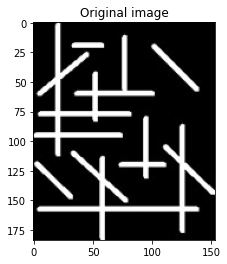

In [29]:
plt.imshow(lines_1_chan, cmap = 'gray')
plt.title('Original image');

"Only the vertical lines should remain after the opening." - Piazza post @61

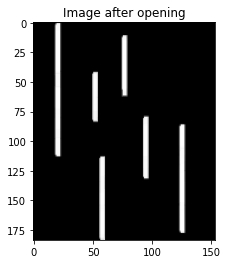

In [43]:
selem_2 = skim_morph.rectangle(10,3)
bin_opened_2 = skim_morph.opening(lines_1_chan, selem_2)
plt.imshow(bin_opened_2, cmap = 'gray')
plt.title('Image after opening');

We threshold this.

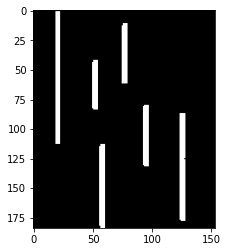

In [42]:
thresh_temp = np.where(bin_opened_2>=100, 1, 0)
plt.imshow(thresh_temp, cmap = 'gray');

In [44]:
strel = np.ones((3,3))

In [45]:
thresholded_bin_labeled, num = scipy_im_measure.label(thresh_temp, strel)

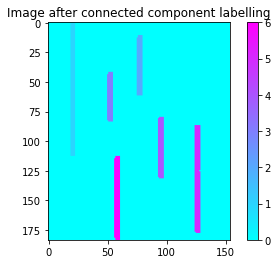

In [53]:
plt.imshow(thresholded_bin_labeled, cmap = 'cool')
plt.colorbar()
plt.title('Image after connected component labelling');

In [70]:
line_centroid_list = []
line_length_list = []
for i in range(1,num+1):
    
    pos = np.asarray(np.where(thresholded_bin_labeled == i))
    centroid_pos = np.mean(pos, axis = 1)
    line_len = pos[0][-1] - pos[0][0]
    line_centroid_list.append(centroid_pos)
    line_length_list.append(line_len)

In [77]:
line_index = [i+1 for i in range(6)]
df_index = pd.DataFrame(line_index, columns=['Line Index'])
df_line_centroid = pd.DataFrame(line_centroid_list, columns=['Row number', 'Column number'])
df2_line_centroid = pd.DataFrame(line_length_list, columns = ['Length of line'])
df3_line_centroid = pd.concat([df_index, df_line_centroid,df2_line_centroid], axis = 1)
df3_line_centroid

,Line Index,Row number,Column number,Length of line
0,1,56.500000,20.500000,111
1,2,36.193676,77.015810,50
2,3,62.594203,52.028986,41
3,4,105.500000,95.015504,51
4,5,131.916115,126.000000,90
5,6,148.000000,58.022792,70


The structuring element I used for opening in this problem was:

selem_2 = skim_morph.rectangle(10,3)

It is displayed in the code block below.

In [86]:
selem_2

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

### Problem 3

(i) Write a function that takes as inputs a greyscale 8-bit (uint8) image, a scalar s ∈ [1, 7] and
performs uniform quantization over the entire range [0, 255] so that the output is quantized
to an s-bit image. You may use loops for this part if necessary

In [88]:
def unif_quantizer(im, num_bits):
    
    def interval_extractor(bit):
        """returns a list of intervals given number of bits, assuming that each pixel is represented by 8 bits"""
        smol = int(256/2**bit)
        list_intervals = []
        for i in range(1, 2**bit):
            list_intervals.append(smol*i)
        return(list_intervals)
    
    def whole_partition(partition):
        """prepends 0 and appends 256 to partition"""
        partition2 = np.insert(partition, 0, 0)
        partition2 = np.append(partition2, 256)
        return(partition2)
    
    def unif_codebook_generator(full_ints):
        """creates codebook from modified partition array given uniform quantization"""
        unif_codebook = []
        for i in range(len(full_ints)-1):
            cb_element = (full_ints[i+1] + full_ints[i])//2 # to ensure this is always an integer
            unif_codebook.append(cb_element)
        return(unif_codebook)
    
    partition = interval_extractor(num_bits)
    full_partition = whole_partition(partition)
    codebook = unif_codebook_generator(full_partition)
    house = np.zeros(im.shape)

    for i in range(len(codebook)):
        house = np.where((im>full_partition[i]) & (im<=full_partition[i+1]),codebook[i],house)

    return(house)

(ii) For the images lena512.tif and diver.tif, calculate the MSE values for s ∈ [1,7] using both  
your uniform quantizer and the Lloyd-Max quantizer (you may use loops for the Lloyd-Max  
quantizer as well). Plot the results (MSE versus number of bits). Show one plot for lena512.tif  
(with both uniform and Lloyd-Max quantization) and another plot for diver.tif. Compare the  
results for the different quantizers/images and explain them. That is, why does one quantizer  
outperform the other, and why is the performance gap larger for one image than for the  
other?

In [90]:
def lloyd_max_quantizer(imej, s):
    
    [M, N] = imej.shape
    training_set = np.reshape(imej,(N*M,1))
    [partition, codebook] = lloyds(training_set, [2**(s)])

    def whole_partition(partition):
        partition2 = np.insert(partition, 0, 0)
        partition2 = np.append(partition2, 256)
        return(partition2)

    partition3 = whole_partition(partition)

    house = np.zeros(imej.shape)

    for i in range(len(codebook)):
        house = np.where((imej>partition3[i]) & (imej<=partition3[i+1]),codebook[i],house)
        
    return(house)

In [91]:
def MSE_calc(im1, im2):
    
    assert(im1.shape == im2.shape)
    
    num_pixels = im1.shape[0]*im1.shape[1]
    err = im1 - im2
    sq_err = err**2
    sum_sq_err = np.sum(sq_err)
    mean_sq_err = sum_sq_err/num_pixels
    
    return(mean_sq_err)

In [92]:
lena = image.imread('lena512.tif')[:,:,0]
diver = image.imread('diver.tif')

In [93]:
unif_MSE_lena = []
lm_MSE_lena = []

for i in range(6):
    
    s = i + 1
    
    imej_sbit_unif = unif_quantizer(lena, s)
    imej_sbit_lm = lloyd_max_quantizer(lena, s)
    
    MSE_sbit_uniform = MSE_calc(lena, imej_sbit_unif)
    MSE_sbit_lm = MSE_calc(lena, imej_sbit_lm)
    
    
    unif_MSE_lena.append(MSE_sbit_uniform)
    lm_MSE_lena.append(MSE_sbit_lm)
    
    
unif_MSE_diver = []
lm_MSE_diver = []

for i in range(6):
    
    s = i + 1
    
    imej_sbit_unif = unif_quantizer(diver, s)
    imej_sbit_lm = lloyd_max_quantizer(diver, s)
    
    MSE_sbit_uniform = MSE_calc(diver, imej_sbit_unif)
    MSE_sbit_lm = MSE_calc(diver, imej_sbit_lm)
    
    
    unif_MSE_diver.append(MSE_sbit_uniform)
    lm_MSE_diver.append(MSE_sbit_lm)

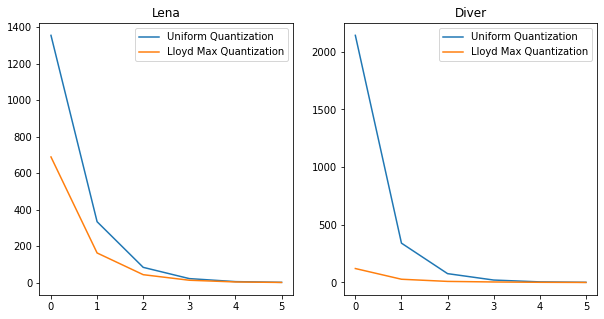

In [94]:
fig = plt.figure(figsize = [10,5])
ax = fig.add_subplot(121)
ax.plot(unif_MSE_lena, label = 'Uniform Quantization')
ax.plot(lm_MSE_lena, label = 'Lloyd Max Quantization')
ax.legend()
ax.set_title('Lena')

ax = fig.add_subplot(122)
ax.plot(unif_MSE_diver, label = 'Uniform Quantization')
ax.plot(lm_MSE_diver, label = 'Lloyd Max Quantization')
ax.legend()
ax.set_title('Diver');

Compare the results for the different quantizers/images and explain them. That is, why does one quantizer outperform the other, and why is the performance gap larger for one image than for the other?

1. For both images, the Lloyd Max Quantizer performs significantly better than the Uniform Quantizer.
2. The absolute difference in performance between the two decreases with increasing number of bits.
3. The performance gap for the Diver image is higher than the Lena image.

The lloyd max quantizer quantizes the image with the motive of reducing mean squared loss between the image to 
be quantized, and the quantized image. Hence, when we plot the mean squared error, we expect it to be less for 
images quantized using the Lloyd Max algorithm.
Hence, the codebook and partition returned by the Lloyd max function is always better suited to minimize MSE.
This is why the Lloyd Max quantizer performs better than the Uniform quantizer.

That is, the uniform quantization algorithm performs poorly on the diver image.
We investigate by plotting all the uniformly quantized images against the lloyd max quantized images of the diver.
For comparison, we will also plot the same for the lena image.

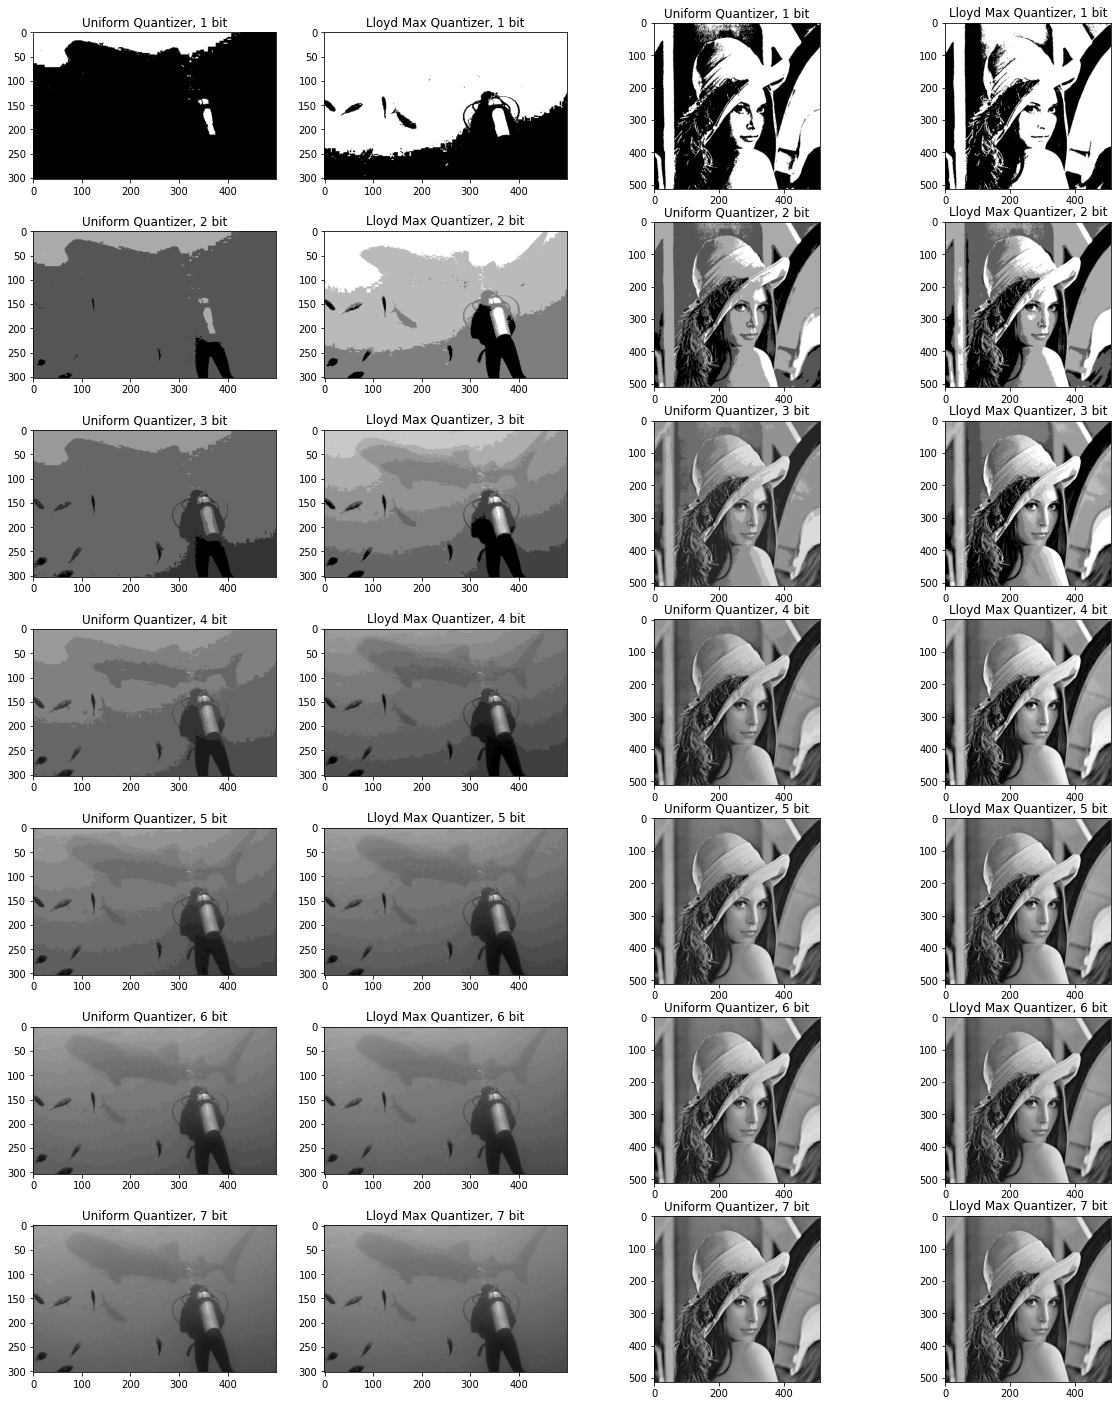

In [97]:
fig, axs = plt.subplots(7,4, figsize = [20,25])
for i in range(7):
    s = i + 1
    imej_sbit_unif = unif_quantizer(diver, s)
    axs[i,0].imshow(imej_sbit_unif,cmap = 'gray')
    axs[i,0].set_title('Uniform Quantizer, {0} bit'.format(s))
    imej_sbit_lm = lloyd_max_quantizer(diver, s)
    axs[i,1].imshow(imej_sbit_lm, cmap = 'gray')
    axs[i,1].set_title('Lloyd Max Quantizer, {0} bit'.format(s))
    
    imej_sbit_unif_lena = unif_quantizer(lena, s)
    axs[i,2].imshow(imej_sbit_unif_lena,cmap = 'gray')
    axs[i,2].set_title('Uniform Quantizer, {0} bit'.format(s))
    imej_sbit_lm_lena = lloyd_max_quantizer(lena, s)
    axs[i,3].imshow(imej_sbit_lm_lena, cmap = 'gray')
    axs[i,3].set_title('Lloyd Max Quantizer, {0} bit'.format(s))
    

Further, we also plot the histograms for both images.

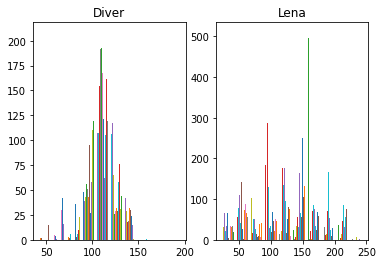

In [98]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.hist(diver)
ax1.set_title('Diver')
ax2 = fig.add_subplot(122)
ax2.hist(lena)
ax2.set_title('Lena');

By observing the histograms of the two images, we can see that the diver histogram is less 'equalized' than lena.

Upon observing the quantization of the diver image, we see that the uniform quantizer performs badly, whereas this
is not the case for lena.

This is because lena's histogram is more equalized than diver. The uniform equalizer has hard coded partitions
and codebooks, so if large parts of the image lie below or above a certain threshold, it will perform badly.

On the other hand, the Lloyd Max equalizer's partitions and codebook vary from image to image, and since it is 
built with the express purpose of minimizing mean squared loss, it sets the partitions and codebooks such that
mean squared loss is minimized for every level of quantization.

#### (iii) Now use global histogram equalization on lena512.tif and on diver.tif to generate two new images, for example:

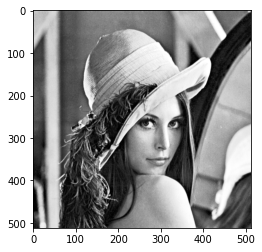

In [100]:
he_lena = cv2.equalizeHist(lena)
plt.imshow(he_lena, cmap = 'gray')

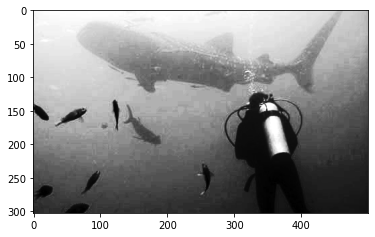

In [101]:
he_diver = cv2.equalizeHist(diver)
plt.imshow(he_diver, cmap = 'gray')

#### Repeat part (ii) for these two new images. Compare them with the previous set of plots. What has happened to the gap in MSE between the two quantization approaches and why?

In [102]:
unif_MSE_he_lena = []
lm_MSE_he_lena = []

for i in range(6):
    
    s = i + 1
    
    imej_sbit_unif = unif_quantizer(he_lena, s)
    imej_sbit_lm = lloyd_max_quantizer(he_lena, s)
    
    MSE_sbit_uniform = MSE_calc(he_lena, imej_sbit_unif)
    MSE_sbit_lm = MSE_calc(he_lena, imej_sbit_lm)
    
    
    unif_MSE_he_lena.append(MSE_sbit_uniform)
    lm_MSE_he_lena.append(MSE_sbit_lm)
    
    
unif_MSE_he_diver = []
lm_MSE_he_diver = []

for i in range(6):
    
    s = i + 1
    
    imej_sbit_unif = unif_quantizer(he_diver, s)
    imej_sbit_lm = lloyd_max_quantizer(he_diver, s)
    
    MSE_sbit_uniform = MSE_calc(he_diver, imej_sbit_unif)
    MSE_sbit_lm = MSE_calc(he_diver, imej_sbit_lm)
    
    
    unif_MSE_he_diver.append(MSE_sbit_uniform)
    lm_MSE_he_diver.append(MSE_sbit_lm)

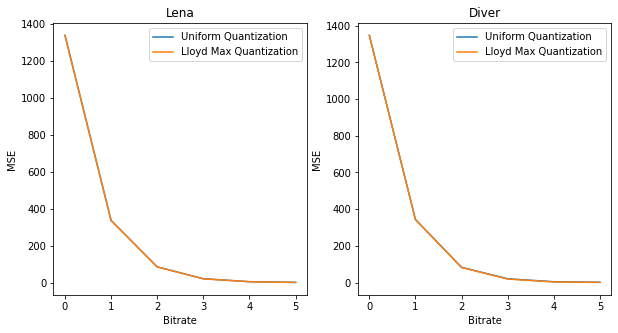

In [103]:

fig = plt.figure(figsize = [10,5])
ax = fig.add_subplot(121)
ax.plot(unif_MSE_he_lena, label = 'Uniform Quantization')
ax.plot(lm_MSE_he_lena, label = 'Lloyd Max Quantization')
ax.legend()
ax.set_title('Lena')
ax.set_ylabel('MSE')
ax.set_xlabel('Bitrate')
ax2 = fig.add_subplot(122)
ax2.plot(unif_MSE_he_diver, label = 'Uniform Quantization')
ax2.plot(lm_MSE_he_diver, label = 'Lloyd Max Quantization')
ax2.legend()
ax2.set_title('Diver')
ax2.set_ylabel('MSE')
ax2.set_xlabel('Bitrate');

The gap in the MSE of the Uniform Quantizer and the Lloyd Max Quantizer has reduced to almost 0.  
Reason:  
The optimal partition levels returned by the Lloyd Max quantizer came out to be the same as that of the uniform quantizer, since histogram equalization by definition changes the probability mass function of the image, and Lloyd Max quantization intervals are a function of the pmf.

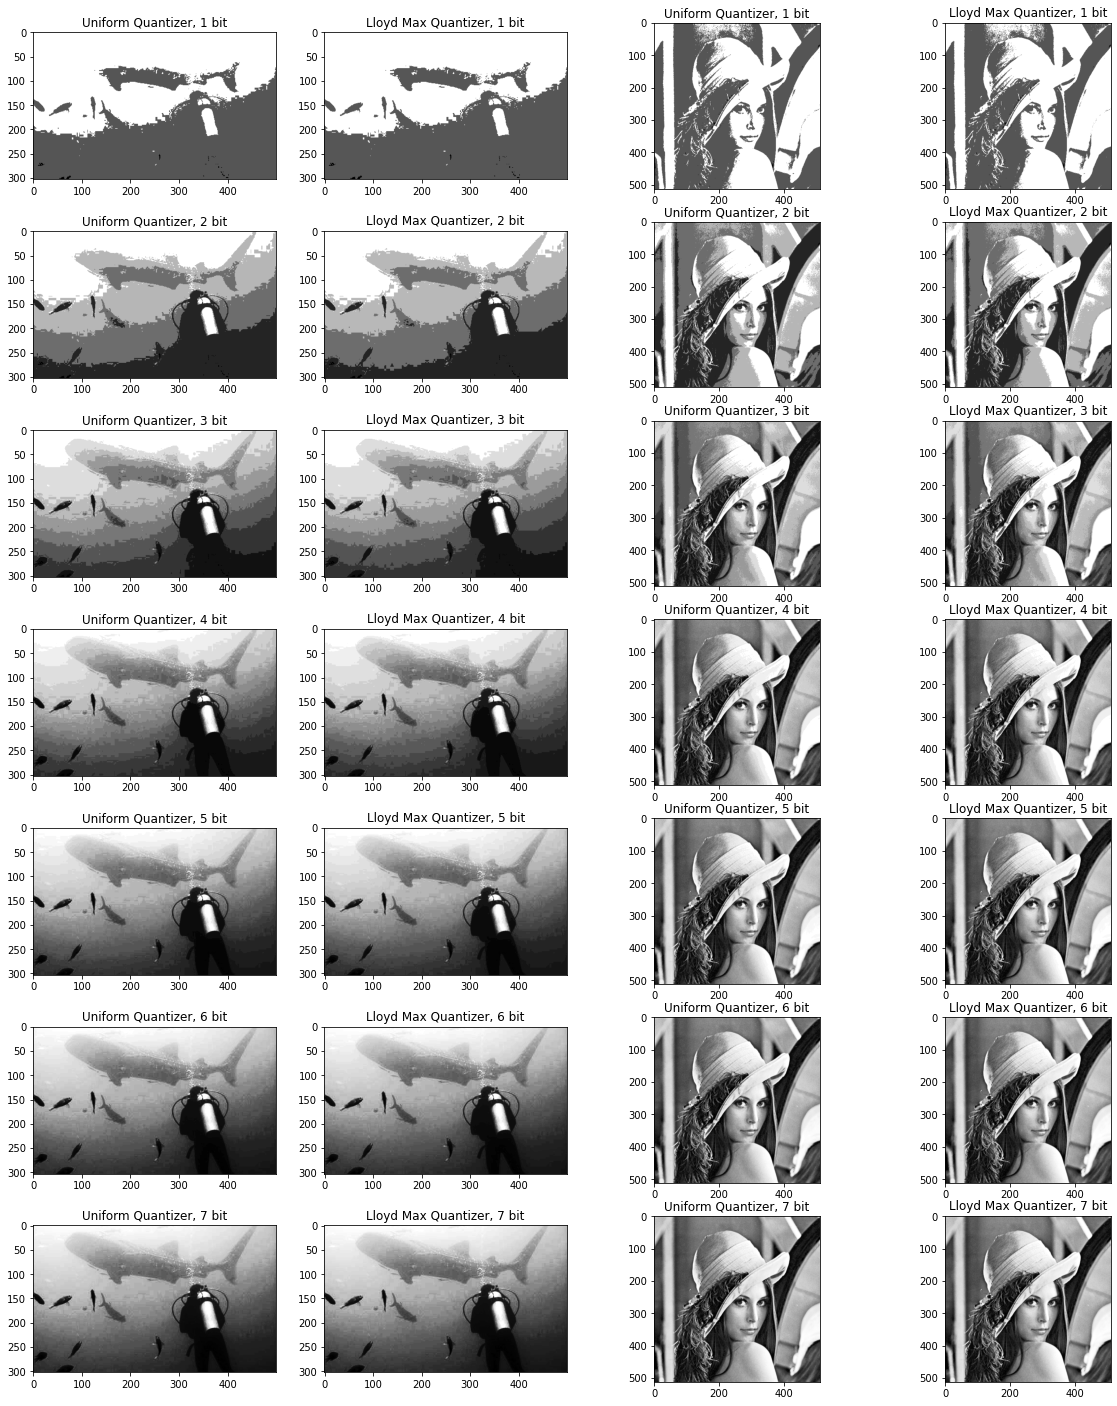

In [104]:
fig, axs = plt.subplots(7,4, figsize = [20,25])
for i in range(7):
    s = i + 1
    imej_sbit_unif = unif_quantizer(he_diver, s)
    axs[i,0].imshow(imej_sbit_unif,cmap = 'gray')
    axs[i,0].set_title('Uniform Quantizer, {0} bit'.format(s))
    imej_sbit_lm = lloyd_max_quantizer(he_diver, s)
    axs[i,1].imshow(imej_sbit_lm, cmap = 'gray')
    axs[i,1].set_title('Lloyd Max Quantizer, {0} bit'.format(s))
    
    imej_sbit_unif_lena = unif_quantizer(he_lena, s)
    axs[i,2].imshow(imej_sbit_unif_lena,cmap = 'gray')
    axs[i,2].set_title('Uniform Quantizer, {0} bit'.format(s))
    imej_sbit_lm_lena = lloyd_max_quantizer(he_lena, s)
    axs[i,3].imshow(imej_sbit_lm_lena, cmap = 'gray')
    axs[i,3].set_title('Lloyd Max Quantizer, {0} bit'.format(s))
    

(iv) Why is the MSE of the 7-bit Lloyd-Max quantizer zero or near zero for the equalized images? One might have thought that equalization is not to the advantage of the Lloyd-Max
quantizer, because equalizing the histogram should be flattening the distribution, making
it more uniform, which should be to the advantage of the uniform quantizer. Explain this
phenomenon.